In [16]:
from Utils import sigmoid
from ExperientalTools import GridSearch

%reload_ext autoreload
%autoreload 2

In [17]:
parameter_grid = dict(
    hidden=[*range(10,500,10)],
    regularization =  [1e-01, 5e-02, 1e-02, 5e-03, 1e-03],
                       #5e-04, 1e-04, 5e-05, 1e-05, 5e-06, 1e-06,
    
                       #5e-07, 1e-07, 5e-08],
    activation_fun = [sigmoid] #,ReLU,tanH]
)   

2.23604845117064e-06
13464.475500404675
3401.5008849932833
894.296478595565
268.7889026935391
111.99503049797231
72.01339164417564
61.18584019496347
57.66754866887401
56.00952084585701
54.84948617554682
53.84487196902746
52.90808703651903
52.0155946290901
51.160114761273604
50.338593326117106
49.54914081774975
48.79023630062342
48.06051134502939
47.358686362269644
46.683548915850224
46.03394453560165
45.40877170730922
44.80697846927815
44.227559727573976
43.66955494308579
43.132046039821276
42.61415546344306
42.11504435427677
41.633910815536225
41.16998826554834
40.722543866775034
40.29087702648888
39.87431796505116
39.47222634835081
39.08398998133158
38.70902355977702
38.3467674777038
37.996686687857654
37.658269612931896
37.331027105241056
37.01449145268632
36.70821542894828
36.411771385934685
36.12475038659981
35.84676137633599
35.57743039121843
35.31639980146075
35.063327588512614
34.81788665430016
34.57976416117722
34.34866090121901
34.12429069355103
33.906379808464386
33.69466641

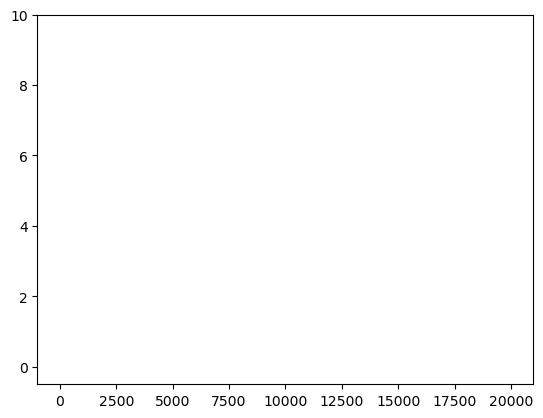

In [23]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from ExtremeNN import ENeuralN

train_set = pd.read_csv("datasets/ML-CUP21-TR.csv", header=None, index_col=0)

# We have training set tr_x 1182 columns and 10 rows
tr_x, tr_y = train_set.iloc[:, :10].to_numpy(), train_set.iloc[:, 10:].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(tr_x, tr_y, test_size=0.33)
x_train, x_val = x_train.T, x_val.T
y_train, y_val = y_train.T, y_val.T


nn = ENeuralN(10, 700, 0.001,sigmoid)
nn.fit_fista(x_train, y_train, iter_= 20000)

In [19]:
GridSearch(train_path="datasets/ML-CUP21-TR.csv",
           test_path="datasets/ML-CUP21-TS.csv",
           configs=parameter_grid)

100%|██████████| 245/245 [01:21<00:00,  2.99it/s, minMSE=1.88]


The best configuration is  {'activation_fun': <function sigmoid at 0x0000025230E82020>, 'hidden': 450, 'regularization': 0.05}
Train error  1.3670584998434108  Validation error 1.8758314125664242
Test error  1.9293813977159278
